# TRAIN KERAS MODEL - Ayukngaji 

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import math
import os
import random
from tensorflow.python.platform import gfile
import librosa
import librosa.display as ld

#for removing future warnings
import warnings
warnings.filterwarnings('ignore')
from array import array

C:\Anaconda3\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Note: import keras seperti ini.

In [2]:
# from tf.keras.models import Sequential  # Tidak bisa!
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import InputLayer, Input
from tensorflow.python.keras.layers import Reshape, MaxPooling2D
from tensorflow.python.keras.layers import Conv2D, Dense, Flatten
from tensorflow.python.keras.layers import Embedding, LSTM

This was developed using Python 3.6 (Anaconda) and TensorFlow version:

In [3]:
tf.__version__

'1.6.0'

In [4]:
tf.keras.__version__

'2.1.3-tf'

## Manual load Spectogram

Berikut tools untuk load batch

In [16]:
"""
DAAATASET
"""
DEBUG = False
PATH_TRAIN = os.getcwd()+'/data/train'
PATH_TEST = os.getcwd()+'/data/test'
LOGDIR = 'log/'
TEST_LOGDIR = 'log_test/'
LABEL_TO_INDEX_MAP = {}
WIDTH = 1025
HEIGHT = 1
NUM_LABELS = 0
BATCHRUN = 10
EPOCHS = 5
msframe = 320 #jumlah frame yang mau dianalisa
sequence = 5 #jumlah deret yang di ambil

In [6]:
def init(path):
    labels = os.listdir(path)
    index = 0
    for label in labels:
        LABEL_TO_INDEX_MAP[label] = index
        index += 1
        
    global NUM_LABELS
    NUM_LABELS = len(LABEL_TO_INDEX_MAP)
    print(LABEL_TO_INDEX_MAP)

In [7]:
def one_hot_encoding(label):
    encoding = [0] * len(LABEL_TO_INDEX_MAP)
    encoding[LABEL_TO_INDEX_MAP[label]] = 1
    return encoding

In [8]:
def get_mfcc(wave_path, PAD_WIDTH=WIDTH):
    #print(wave_path)
    wv, sr = librosa.load(wave_path, sr=16000)
    ln_max = len(wv)

    #jumlah frame
    jf = len(wv)// msframe
    nD = []
    for i in range(jf-1):
        
        wav = wv[(msframe*i):(msframe*i)+msframe]
        #print(wav)
        D = librosa.amplitude_to_db(librosa.magphase(librosa.stft(wav))[0])

        #if want to see the graph
        #ld.specshow(D, y_axis='log')
        #plt.title("Power db - "+ str(D.shape))
        #plt.show()
        #print(D)
        
        #put into array
        nD.append(D)
    return nD
                                
def get_mfcc2(wave_path, PAD_WIDTH=WIDTH):
    if DEBUG:
        print(wave_path)

    #mfcc
    #wave, sr = librosa.load(wave_path, mono=True, duration=0.5)
    #mfccs = librosa.amplitude_to_db(librosa.stft(wave))
    #mfccs = librosa.feature.mfcc(wave,sr=22050,n_mfcc=HEIGHT)
    #mfccs = np.pad(mfccs,((0,0), (0, PAD_WIDTH - len(mfccs[0]))), mode='constant')
    
    #test spectogram
    wv, sr = librosa.load(wave_path, sr=16000)
    ln_max = len(wv)-320
    f = random.randint(0,ln_max)
    wv = wv[f:f+320]
    
    #sr, wv = read(filename)
    #wv = wv.astype('float')
    D = librosa.amplitude_to_db(librosa.magphase(librosa.stft(wv))[0])
    print(wave_path,D.shape)
    
    #return mfccs
    return D

In [9]:
def get_batch(batch_size, path):
    X = []
    Y = []
    random.seed(5896)
    path = os.path.join(path,'*', '*.wav')
    waves = gfile.Glob(path)
    while True:
        random.shuffle(waves)
        for wave_path in waves:
            _,label = os.path.split(os.path.dirname(wave_path))
            X.append(get_mfcc(wave_path))
            Y.append(one_hot_encoding(label))

            if (len(X) == batch_size):
                yield X, Y
                X = []
                Y = []

In [10]:
def my_plot(data, title=""):
    H = data
    fig = plt.figure(figsize=(2, 2))

    ax = fig.add_subplot(111)
    ax.set_title(title)
    plt.imshow(H)
    ax.set_aspect('equal')

    #cax = fig.add_axes([0.12, 0.1, 0.78, 0.8])
    cax.get_xaxis().set_visible(False)
    cax.get_yaxis().set_visible(False)
    cax.patch.set_alpha(0)
    cax.set_frame_on(False)
    #plt.colorbar(orientation='vertical')
    plt.show()

## Data Dimensions

setting ukuran matriks

In [11]:
# We know that MNIST images are 28 pixels in each dimension.
img_size_x = WIDTH
img_size_y = HEIGHT

# Images are stored in one-dimensional arrays of this length.
img_size_flat = img_size_x * img_size_y

# Tuple with height and width of images used to reshape arrays.
# This is used for plotting the images.
img_shape = (img_size_x, img_size_y)

# Tuple with height, width and depth used to reshape arrays.
# This is used for reshaping in Keras.
img_shape_full = (img_size_x, img_size_y, 1)

# Number of colour channels for the images: 1 channel for gray-scale.
num_channels = 1

# Number of classes, one class for each of 10 digits.
num_classes = 6

### Helper-function buat plot gambar

Function used to plot 9 images in a 3x3 grid, and writing the true and predicted classes below each image.

In [12]:
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(img_shape), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

## Sequential Model

Model dari Keras

In [13]:
model3 = Sequential()
#model3.add(Embedding(20000,128))

model3.add(LSTM(128,dropout=0.2,recurrent_dropout=0.2,input_shape=(5,1025),return_sequences=True))
model3.add(LSTM(128,dropout=0.2,recurrent_dropout=0.2,input_shape=(5,1025),return_sequences=False))

model3.add(Dense(6,activation='sigmoid'))
model3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [14]:
from tensorflow.python.keras.optimizers import Adam

optimizer = Adam(lr=1e-4)

### Training

Tempat training keseluruhan

In [17]:
init(PATH_TRAIN)
batch = get_batch(BATCHRUN,PATH_TRAIN)
X, Y = next(batch)

{'ba': 0, 'ju': 1, 'mi': 2, 'nu': 3, 'si': 4, 'ta': 5}


In [18]:
x_train=[]
y_train=[]
for i in range(len(X)):
    lx = len(X[i])
    ld = len(X[i]) // sequence
    ds = []
    for ll in range(len(X[i])-sequence):
        ds = X[i][ll:ll+sequence]
        #print(ds)
        x_train.append(np.array(ds).reshape(5,1025))
        y_train.append(Y[i])

In [20]:
xx = np.array(x_train, dtype=float)
yy = np.array(y_train, dtype=float)

In [22]:
xx.shape

(10466, 5, 1025)

In [23]:
model3.fit(x=np.array(xx),y=np.array(yy), epochs=50, verbose=2 )

Epoch 1/50
 - 8s - loss: 1.7597 - acc: 0.1986
Epoch 2/50
 - 7s - loss: 1.7570 - acc: 0.2040
Epoch 3/50


KeyboardInterrupt: 

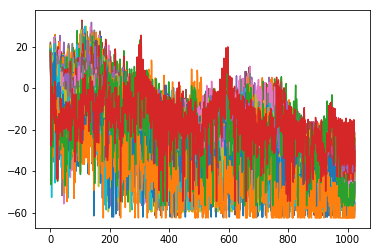

In [97]:
for i in X[20]:
    plt.plot(i)

# STOP TRAINING DISINI

In [ ]:
EPOCHS = 50
model3.fit(x=np.array(xx),
          y=np.array(yy),
          epochs=EPOCHS, batch_size=BATCHRUN)

### Evaluation

Now that the model has been trained we can test its performance on the test-set. This also uses numpy-arrays as input.

In [ ]:
result = model3.evaluate(x=np.array(xx),
                        y=np.array(yy))

Print performa test

In [ ]:
for name, value in zip(model3.metrics_names, result):
    print(name, value)

Or we can just print the classification accuracy.

In [ ]:
print("{0}: {1:.2%}".format(model3.metrics_names[1], result[1]))

### Prediksi

coba disini bikin prediksi

In [ ]:
y_pred = model3.predict(x=np.array(xx)[9].reshape(1,5,1025))

In [ ]:
np.array(xx)[9].reshape(1,5,1025).shape

In [ ]:
y_pred

Ambil prediksi jadikan integer

In [ ]:
cls_pred = np.argmax(y_pred,axis=1)

## Save & Load Model

In [ ]:
path_model = 'model.keras'

In [ ]:
model3.save(path_model)

Hapus model

In [ ]:
del model3

Import lagi

In [ ]:
from tensorflow.python.keras.models import load_model

Panggil model

In [ ]:
model3 = load_model(path_model)

Coba test model yang di load

In [ ]:
BATCHRUN=10
init(PATH_TEST)
batch = get_batch(BATCHRUN,PATH_TEST)
X, Y = next(batch)

x_train=[]
y_train=[]
for i in range(len(X)):
    lx = len(X[i])
    ld = len(X[i]) // sequence
    ds = []
    for ll in range(len(X[i])-sequence):
        ds = X[i][ll:ll+sequence]
        #print(ds)
        x_train.append(np.array(ds).reshape(5,1025))
        y_train.append(Y[i])

xx = np.array(x_train, dtype=float)
yy = np.array(y_train, dtype=float)

In [ ]:
y_pred = model3.predict(x=np.array(xx)[39].reshape(1,5,1025))

In [ ]:
y_pred

In [ ]:
yy[39]

In [ ]:
cls_pred = np.argmax(y_pred, axis=1)

In [98]:
#Cek akurasi
for name, value in zip(model.metrics_names, result):
    print(name, value)

NameError: name 'model' is not defined

In [99]:
import audioop
import pyaudio

class AudioFile:
    """
    Untuk menggunakan object Audiofile gunakan
    a = a.AudioFile('namafile.wav')
    lalu gunakan
    a.play
    a.record
    dan lain2
    
    """
    chunk = 320 #2048
    FORMAT = pyaudio.paInt16
    CHANNELS = 1
    RATE = 16000
    length_capture = 20  #20 ms
    overlap_frame = 4    #4 ms
    start_at = 7         #maybe not used
    end_at = 100
    DEBUG = False
    sequence = 5

    def __init__(self, file):
        self.file = file

    def play(self,filename=""):
        if filename=="": filename=self.file
        self.wf = wave.open(filename, 'rb')

        # instantiate PyAudio (1)
        self.p = pyaudio.PyAudio()

        # open stream (2)
        self.stream = self.p.open(format=self.p.get_format_from_width(self.wf.getsampwidth()),
                channels=self.wf.getnchannels(),
                rate=self.wf.getframerate(),
                output=True)

        # read data
        self.data = self.wf.readframes(self.chunk)

        # play stream (3)
        while len(self.data) > 0:
            self.stream.write(self.data)
            self.data = self.wf.readframes(self.chunk)

        # stop stream (4)
        self.stream.stop_stream()
        self.stream.close()

        # close PyAudio (5)
        self.p.terminate()

    def record(self, length=3, thres=0, filename=""):
        if filename=="": filename=self.file
        """Merekam length dalam detik, thres adalah sensitivitas mic"""
        self.p = pyaudio.PyAudio()
 
        # start Recording
        self.stream = self.p.open(format=self.FORMAT, channels=self.CHANNELS,
                rate=self.RATE, input=True,
                frames_per_buffer=self.chunk)
        """record to file"""
        self.frames = []
        self.temp_frames = []
        print("Recording")
        for i in range(0, int(self.RATE / self.chunk * length)):
            
            data = self.stream.read(self.chunk)
            rms = audioop.rms(data,2)
            if rms >= thres:
                self.frames.append(data)
           
                
        print("finished recording")
 
        # stop Recording
        self.stream.stop_stream()
        self.stream.close()
        
        
        self.wf = wave.open(filename, 'wb')
        self.wf.setnchannels(self.CHANNELS)
        self.wf.setsampwidth(self.p.get_sample_size(self.FORMAT))
        self.wf.setframerate(self.RATE)
        self.wf.writeframes(b''.join(self.frames))
        self.wf.close() 
        return b''.join(self.frames)
        
    def test(self, length=5):
        """Merekam length dalam detik, thres adalah sensitivitas mic"""
        self.p = pyaudio.PyAudio()
 
        # start Recording
        self.stream = self.p.open(format=self.FORMAT, channels=self.CHANNELS,
                rate=self.RATE, input=True,
                frames_per_buffer=self.chunk)
        """record to file"""
        self.frames = []
        self.temp_frames = []
        print("Mulai Recording\n...  Bersiap diam")
        time.sleep(2)
        print("Sekarang diam.")
        
        self.rms_sepi = []
        self.rms_bicara = []
        for i in range(0, int(self.RATE / self.chunk * (length / 2))):
            
            data = self.stream.read(self.chunk)
            rms = audioop.rms(data,2)
            self.rms_sepi.append(rms)
        
        time.sleep(2)
        print("\nSekarang bicara sewajarnya")
        for i in range(0, int(self.RATE / self.chunk * (length / 2))):
            
            data = self.stream.read(self.chunk)
            rms = audioop.rms(data,2)
            self.rms_bicara.append(rms)

        time.sleep(1)
        
        print("\nmax Threshold Sepi:", max(self.rms_sepi))
        print("max Threshold Bicara:", max(self.rms_bicara))
                
        print("Selesai merekam, gunakan nilai sedikit diatas Threshold sepi ")
 
        self.stream.stop_stream()
        self.stream.close()

    def aufile(self):
        return self.file
    
    def stream_pred(self, length=3, thres=600, frame=5):
        self.p = pyaudio.PyAudio()


        # start Recording
        self.stream = self.p.open(format=self.FORMAT, channels=self.CHANNELS,
                rate=self.RATE, input=True,
                frames_per_buffer=self.chunk)
        """record to file"""
 
        self.frames = []

        print("Recording")
        
        self.fl=0
        self.aprd=[]
        for i in range(0, int(self.RATE / self.chunk * length)):
            self.fl += 1
            self.prd=[]
            for pr in range(sequence):
                data = self.stream.read(self.chunk)
                self.tmp = []
                self.tmp.append(data)
                print(self.tmp)
                
                #buat jadi max 1 float
                
                
                
                
                D = librosa.amplitude_to_db(librosa.magphase(librosa.stft(self.tmp))[0])
                self.prd.append([D])
            self.aprd.append(np.array(self.prd))
            y_pred = model3.predict(x=self.aprd)
            print(y_pred)
            self.aprd=[]

                
        print("finished recording")
        self.files=[]
        return self.files

    def seq_write(self, frames, no_seq):
        self.fn = self.file.split('.wav')[0]
        if self.DEBUG: print(self.fn)
        self.fn = self.fn + str(no_seq)+'-f.wav'
        self.wf = wave.open(self.fn, 'wb')
        self.wf.setnchannels(self.CHANNELS)
        self.wf.setsampwidth(self.p.get_sample_size(self.FORMAT))
        self.wf.setframerate(self.RATE)
        self.wf.writeframes(b''.join(self.frames))
        self.wf.close()
        print("recorded:",self.fn)

    def specs(self, filename="", offset=0.0, duration=None, sr=22050):
        if filename=="": filename=self.file
        wv, sr = librosa.load(filename, offset=offset, duration=duration, sr=sr)
        #sr, wv = read(filename)
        #wv = wv.astype('float')
        D = librosa.amplitude_to_db(librosa.magphase(librosa.stft(wv))[0])
        librosa.display.specshow(D, y_axis='log')
        plt.title("Power db - "+ str(D.shape))
        plt.colorbar()
        


In [108]:
import IPython.display as ipd
X = get_mfcc("mytest-16000.wav")
ipd.Audio("mytest-16000.wav")

In [109]:
len(X)

31

In [122]:
x_train=[]
#for i in range(len(X)):
#    lx = len(X)
#    ld = len(X) // sequence
#    ds = []
#    for ll in range(ld-1):
#        #print(ll)
#        ds = X[ll:ll+sequence]
#        ds = np.array(ds,dtype='float')
#        
#        #print(ds)
#        try:
#            x_train.append(np.array(ds).reshape(5,1025))
#        except:
#            pass


for i in range(0,len(X),5):
    ds=[]
    ds = X[i:i+sequence]
xx = np.array(x_train, dtype=float)
xx.shape

(155, 5, 1025)

In [123]:
y_pred = model3.predict(x=xx)

In [124]:
cl = np.argmax(y_pred, axis=1)

In [125]:
len(cl)

155

In [126]:
for t in range(len(cl)):
    print(list(LABEL_TO_INDEX_MAP.keys())[cl[t]])

ju
nu
mi
nu
nu
ju
nu
mi
nu
nu
ju
nu
mi
nu
nu
ju
nu
mi
nu
nu
ju
nu
mi
nu
nu
ju
nu
mi
nu
nu
ju
nu
mi
nu
nu
ju
nu
mi
nu
nu
ju
nu
mi
nu
nu
ju
nu
mi
nu
nu
ju
nu
mi
nu
nu
ju
nu
mi
nu
nu
ju
nu
mi
nu
nu
ju
nu
mi
nu
nu
ju
nu
mi
nu
nu
ju
nu
mi
nu
nu
ju
nu
mi
nu
nu
ju
nu
mi
nu
nu
ju
nu
mi
nu
nu
ju
nu
mi
nu
nu
ju
nu
mi
nu
nu
ju
nu
mi
nu
nu
ju
nu
mi
nu
nu
ju
nu
mi
nu
nu
ju
nu
mi
nu
nu
ju
nu
mi
nu
nu
ju
nu
mi
nu
nu
ju
nu
mi
nu
nu
ju
nu
mi
nu
nu
ju
nu
mi
nu
nu
ju
nu
mi
nu
nu


# TEST DISINI

In [ ]:
a = np.array([1,3,4,5,6])

In [ ]:
aaa=b'\xc0\x00\xf0\x01\xaa\x006\x01\x80\x01\xed\x00\x9f\x01\xcc\x00\xd6\xff\xd4\x00\xae\x00\x0b\x00\xb6\x004\x012\x02\x1b\x028\x01X\x01\xd7\x01\xd0\x01\xd7\x01\x7f\x01}\x01{\x01\xae\x00\xd5\x00\x93\x00k\x00\x8c\x00e\x00y\x00\xbd\x00\x08\x01\xc5\x00\xbb\x00\xbd\x00\x16\x01\xa9\x01\x8a\x01{\x01\xe2\x01D\x01\x15\x01.\x01\xf1\x00#\x01\x17\x01^\x01B\x01\xca\x00\x9c\x00\x85\x00a\x00\\\x00\x96\x00\x8f\x00\x8b\x00\x87\x00\x9b\x00\x9f\x00g\x00\x80\x00\xc7\x00\xec\x00\x13\x01\\\x01\x87\x01j\x01\x87\x01\xb9\x01\xa2\x01\xc8\x01\xd2\x01\xb3\x01\x7f\x01K\x01T\x01^\x01i\x01\x82\x01\xb0\x01\xc9\x01\xbe\x01\x9c\x01I\x013\x01g\x01\xb4\x01\x12\x02!\x02+\x02\x87\x02t\x028\x02n\x02f\x02w\x02\xe1\x02\xf3\x02\xe6\x02\xfe\x02\xd8\x02\x81\x02F\x02!\x02\x04\x02M\x02k\x02D\x02M\x02.\x02\xe9\x01\xe8\x01\xfb\x01\x04\x02H\x02j\x02M\x024\x02\x15\x02\x11\x02L\x02\x86\x02\x8b\x02\xac\x02\xb5\x02\x9e\x02\x8b\x02Q\x02?\x02\x1c\x02\xf9\x01\xbd\x01\x9f\x01\xd3\x01\xd3\x01\xd7\x01\xba\x01\xa5\x01\xa3\x01\xb6\x01\x9a\x01\x8e\x01\xc0\x01\xb4\x01\xa4\x01y\x01#\x01\xe7\x00\xfe\x00\xf8\x00\xfe\x00,\x01 \x01\x0f\x01\x16\x012\x016\x01#\x01\x08\x01W\x01_\x01\x14\x01\r\x01\x11\x01"\x01\x04\x01\x08\x01!\x01\x1e\x01\xf5\x00\xdf\x00\xc5\x00\xa5\x00\xbd\x00\xe7\x00\xc9\x00\x9a\x00\xe0\x00\x1e\x01\xd8\x00\xc2\x00\xd3\x00\xa3\x00\x87\x00{\x00\xb0\x00\xd6\x00\xc8\x00\xda\x00\xdf\x00\xc2\x00\xaa\x00\xcd\x00\x06\x01\x04\x01\xf0\x00\r\x01\xf6\x00\xe4\x00\xdf\x00\x16\x01G\x01\xf5\x00\xbc\x00\xee\x00\xf2\x00\xc9\x00\xfc\x00\x05\x01\xb5\x00\xa9\x00\x19\x01\x1c\x01\xd8\x00\xf2\x00 \x01\x1a\x01\xbf\x00\xb6\x00\xf0\x00\xbe\x00{\x00~\x00o\x00v\x00w\x00\x88\x00q\x00\t\x00P\x00\xa4\x00t\x00/\x00!\x00F\x003\x00$\x00Q\x00@\x00\xf9\xff\xfb\xff\x0b\x00-\x00o\x00`\x004\x00_\x00p\x00v\x00\x85\x00\xa4\x00\x9e\x00t\x00\x87\x00y\x00c\x00\xb4\x00\xea\x00\x97\x00\x97\x00\x83\x00K\x00\x99\x00\xdd\x00\xb6\x00\x92\x00\xc3\x00\xb0\x00\xda\x00\x06\x01\xde\x00\xd5\x00\xc7\x00\xcc\x00\xfb\x001\x01\x1d\x01\xf9\x00\x02\x01\xfe\x00\x12\x018\x01?\x01\x14\x01\x16\x01\x0e\x01\t\x01 \x01\xb3\x00\x9d\x00\xc8\x00\xb3\x00\x9d\x00\xb9\x00\x8e\x00P\x00\x86\x00\x8b\x00Y\x00M\x00S\x00N\x00W\x00U\x00C\x00e\x00\x8e\x00-\x00\x0b\x00a\x00`\x00C\x00]\x00Z\x00\x1a\x00\xf0\xff\x12\x00/\x00^\x00'

In [ ]:
import struct
a = int.from_bytes(aaa,byteorder='little')

In [ ]:
a

In [ ]:
ff=b'\xc0'

In [ ]:
ff

In [ ]:
ff